In [21]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [22]:
import numpy as np
import os
import glob
import pickle
from operator import itemgetter
from Bio import SeqIO
import csv
import scipy
from scipy import stats
from pandas import DataFrame
from sklearn import metrics
import seaborn as sns
import pandas

# Initialization

In [23]:
sample="SEQC_A1A2_B1B2"

ERCC_control_data="/path/to/ERCC_Controls_Analysis.txt"
ERCC_gtf="/path/to/ERCC92.gtf"
Ensemble_gtf="/path/to/genes.GRCh37.ERCC92.gtf"
TAQ="/path/to/TAQ.txt"

# Predictions

In [56]:
diff_g_file="/path/to/dseq_res.tab"


# Functions

In [57]:
def parse_diff_g_results(res_file):
    diff_g={}
    with open(res_file, 'r') as csv_f:
        spamreader = csv.reader(csv_f, delimiter='\t', quotechar='|')
        mat={}
        cnt=-1
        ztpm=0
        for row in spamreader:
            cnt+=1
            if cnt==0:
                continue
            if not row[6]=="NA":
                mat[row[0]]=[float(row[2]),float(row[6])]
        diff_g["res"]=mat
    return diff_g

In [58]:
def find_corr(x,y):
    corr={}
    [r,p]=scipy.stats.spearmanr(x, y) 
    corr['spearman']=[r,p]
    corr['RMSD']=sqrt(np.mean(map(lambda i: (x[i]-y[i])**2,range(len(x)))))
    return corr



In [59]:
def parse_TAQ(TAQ_file,sample):
    TAQ_control={}
    with open(TAQ_file, 'rU') as csv_f:
        spamreader = csv.reader(csv_f, delimiter='\t', quotechar='|')
        cnt=-1       
        for row in spamreader:
            cnt+=1
            if cnt==0:
                header=row[1:]
                continue
            if not row[0] in TAQ_control:
                exps=map(lambda x:float(x)+0.00001,row[1:])
                if sample=="SEQC_A1A2_B1B2":
                    logfc=np.log2((exps[4]+exps[5])/(exps[0]+exps[1]))
                elif sample=="SEQC_C1C2_D1D2":
                    logfc=np.log2((exps[12]+exps[13])/(exps[8]+exps[9]))
                TAQ_control[row[0]]=dict(zip(header,map(float,row[1:])))
                TAQ_control[row[0]]["logfc"]=logfc
    return TAQ_control
TAQ_control=parse_TAQ(TAQ,sample)

In [60]:
def parse_ercc(ercc_file,sample):
    ercc_control={}
    with open(ercc_file, 'r') as csv_f:
        spamreader = csv.reader(csv_f, delimiter='\t', quotechar='|')
        cnt=-1       
        for row in spamreader:
            cnt+=1
            if cnt==0:
                continue
            if sample=='SEQC_A1A2_B1B2':
                ercc_control[row[1]]={"c1":float(row[3]),"c2":float(row[4]),"fc":1/float(row[5]),"logfc":-np.log2(float(row[5]))}
            elif sample=="SEQC_C1C2_D1D2":
                a=float(row[3])
                b=float(row[4])
                c=.75*a+.25*b
                d=.25*a+.75*b
                ercc_control[row[1]]={"c1":c,"c2":d,"fc":d/float(c),"logfc":np.log2(d/float(c))}
                
    return ercc_control
ercc_control=parse_ercc(ERCC_control_data,sample)
                                         


## Read differential expression results

In [32]:
gname_2_ens={}
ens_2_gname={}
with open(Ensemble_gtf, 'r') as csv_f:
    spamreader = csv.reader(csv_f, delimiter='\t', quotechar='|')
    for row in spamreader:
        t_info={k.split()[0]:k.split()[1] for k in ' '.join(row[8:]).split(";")[:-1]}
        gid=t_info["gene_id"][1:-1]
        gname=t_info["gene_name"][1:-1] if "gene_name" in t_info else t_info["gene_id"][1:-1]
        if not gname in gname_2_ens:
            gname_2_ens[gname]=set([gid])
        else:
            gname_2_ens[gname].add(gid)

        if not gid in ens_2_gname:
            ens_2_gname[gid]=set([gname])
        else:
            ens_2_gname[gid].add(gname)
            
                


In [62]:
diff_g_preds=parse_diff_g_results(diff_g_file)


In [63]:
diff_g_res_taq={}
res=diff_g_preds["res"]
cnt=0
for k in (set(gname_2_ens.keys())&set(TAQ_control.keys())):
    kk=set(gname_2_ens[k])& set(res.keys())
    if len(kk)>1:
        cnt+=1
    if kk:
        diff_g_res_taq[k]=res[list(kk)[0]]
print len(diff_g_res_taq),cnt

820 1


In [64]:
diff_g_res_ercc={k:res[k] for k in (set(res.keys())&set(ercc_control.keys()))}
print len(diff_g_res_ercc)

82


## Plots

In [65]:
taq_corr={}
my_res=diff_g_res_taq
taq_genes=TAQ_control.keys()
x=[my_res[k][0] if k in my_res else 0 for k in taq_genes]

x=map(lambda i:max(i,-14),x)
x=map(lambda i:min(i,13),x)
y=[TAQ_control[k]["logfc"] for k in taq_genes]
taq_corr=find_corr(x,y)
print taq_corr

{'spearman': [0.86719397418021449, 9.3367296458066452e-305], 'RMSD': 1.7462318328287452}


In [66]:
sns.set(style="white",font_scale=3)    
logFC_cutoffs=np.arange(0.5,2.5,0.5)
AUC_TAQ={}
for logFC_cutoff in logFC_cutoffs:
    SNs=[0]
    SPs=[1]
    prev_SP=0
    my_res=diff_g_res_taq
    for pval_cutof in sorted(map(lambda x:x[1],my_res.values())):
        taq_genes=TAQ_control.keys()
        T=set(filter(lambda x:abs(TAQ_control[x]["logfc"])>=logFC_cutoff,taq_genes))
        F=set(taq_genes)-set(T)
        homos=set(filter(lambda x:sign(my_res[x][0])==sign(TAQ_control[x]["logfc"]),my_res.keys()))
        P=set(filter(lambda x:my_res[x][1]<=pval_cutof,my_res.keys()))
        N=set(filter(lambda x:my_res[x][1]>pval_cutof,my_res.keys()))
        N=N|(set(taq_genes)-(P|N))                

        TP=T&P&homos
        FP=(P&F)|(P&(T-homos))
        TN=F&N
        FN=T&N
        SN=len(TP)/float(len(TP)+len(FN)+0.00001)
        SP=len(TN)/float(len(TN)+len(FP)+0.00001)
        if SPs[-1]>0.7:
            SNs.append(SN)
            SPs.append(SP)
        prev_SP=SP
    SP_1=SPs[-1]
    SP_2=SPs[-2]
    SN_1=SNs[-1]
    SN_2=SNs[-2]
    SP=0.7
    SN=(SN_2-SN_1)/(SP_2-SP_1+0.0000001)*(SP-SP_1)+SN_1
    SNs[-1]=SN
    SPs[-1]=SP
    AUC_TAQ[logFC_cutoff]=metrics.auc(1-np.array(SPs),SNs)



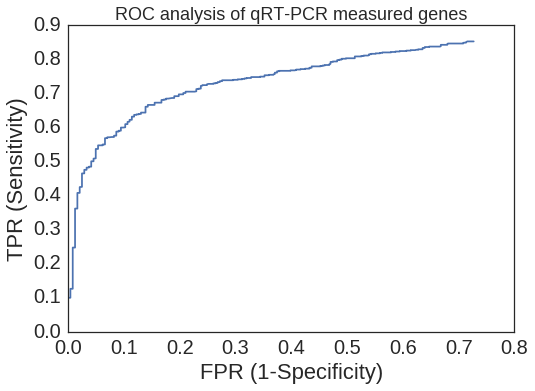

In [104]:
logFC_cutoff=0.5
pval_cutof=0.05
sns.set(style="white",font_scale=2)  
SNs=[0]
SPs=[1]
my_res=diff_g_res_taq
for pval_cutof in sorted(map(lambda x:x[1],my_res.values())):
    taq_genes=TAQ_control.keys()
    T=set(filter(lambda x:abs(TAQ_control[x]["logfc"])>=logFC_cutoff,taq_genes))
    F=set(taq_genes)-set(T)
    homos=set(filter(lambda x:sign(my_res[x][0])==sign(TAQ_control[x]["logfc"]),my_res.keys()))
    P=set(filter(lambda x:my_res[x][1]<=pval_cutof,my_res.keys()))
    N=set(filter(lambda x:my_res[x][1]>pval_cutof,my_res.keys()))
    N=N|(set(taq_genes)-(P|N))                
    TP=T&P&homos
    FP=(P&F)|(P&(T-homos))
    TN=F&N
    FN=T&N
    SN=len(TP)/float(len(TP)+len(FN))
    SP=len(TN)/float(len(TN)+len(FP))
    SNs.append(SN)
    SPs.append(SP)
plot(1-np.array(SPs),SNs)
xlabel("FPR (1-Specificity)")
ylabel("TPR (Sensitivity)")
title("ROC analysis of qRT-PCR measured genes",fontsize=18)

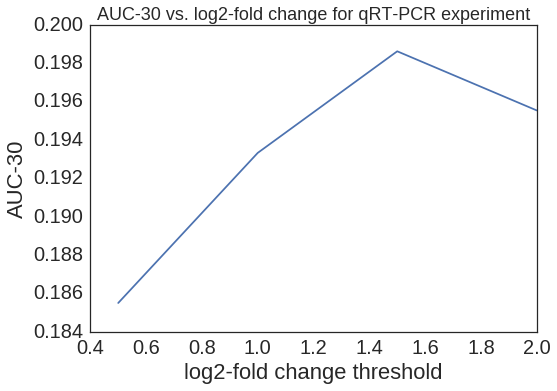

In [106]:
logFC_cutoff=0.5
pval_cutof=0.05
sns.set(style="white",font_scale=2)    
x=logFC_cutoffs
y=[AUC_TAQ[w] for w in logFC_cutoffs]
plot(x,y)
xlabel("log2-fold change threshold")
ylabel("AUC-30")
title("AUC-30 vs. log2-fold change for qRT-PCR experiment",fontsize=18)

In [80]:
taq_corr

{'RMSD': 1.7462318328287452,
 'spearman': [0.86719397418021449, 9.3367296458066452e-305]}

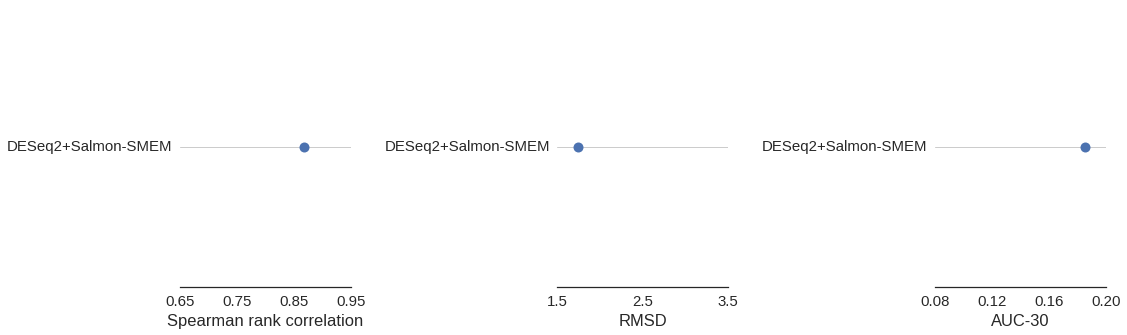

In [108]:
sns.set(style="white",font_scale=1.5)    
my_data=DataFrame([["DESeq2+Salmon-SMEM",taq_corr["spearman"][0],"Spearman rank correlation"],
                  ["DESeq2+Salmon-SMEM",taq_corr["RMSD"],"RMSD"],
                  ["DESeq2+Salmon-SMEM",AUC_TAQ[0.5],"AUC-30"]]
                  ,
                  columns=["tool","score","Measure"])
fig, axes = plt.subplots(1,3,figsize=(16,5))
for iii,key in enumerate(["Spearman rank correlation","RMSD","AUC-30"]):
    ax=axes[iii]
    my_data_=my_data[my_data["Measure"]==key]
    my_data_=my_data_.sort_values(by='score', ascending=[1 if key=="RMSD" else 0])

    cg=sns.stripplot(y="tool", x="score",data=my_data_,size=10, hue="Measure", orient="h",edgecolor="gray",ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel(key)
    ax.legend([])
    ax.xaxis.grid(False)
    if iii==0:
        ax.set_xticks(np.arange(0.65,1,.1))
        ax.set_xlim([0.65,0.95])
    elif iii==1:
        ax.set_xticks(np.arange(1.5,4,1))
        ax.set_xlim([1.5,3.5])
    elif iii==2:
        ax.set_xticks(np.arange(0.08,0.24,.04))
        ax.set_xlim([0.08,0.2])
    ax.yaxis.grid(True)
    sns.despine(bottom=True)
    sns.despine(top=True)
    sns.despine(right=True)
    sns.despine(left=True)
    plt.tight_layout()


In [91]:
ercc_corr={}
my_res=diff_g_res_ercc
ercc_genes=ercc_control.keys()
x=[my_res[k][0] if k in my_res else 0 for k in ercc_genes  ]
x=map(lambda i:max(i,-14),x)
x=map(lambda i:min(i,13),x)
y=[ercc_control[k]["logfc"] for k in ercc_genes  ]
print len(x),len(y)
ercc_corr=find_corr(x,y)


92 92


In [94]:
logFC_cutoff=0.5
pval_cutof=0.05
sns.set(style="white",font_scale=3)  
SNs=[0]
SPs=[1]
my_res=diff_g_res_ercc
for thr in (np.arange(0,3,0.1).tolist()+range(3,100))[::-1]:
    pval_cutof=10**-thr
    ercc_genes=ercc_control.keys()
    T=set(filter(lambda x:abs(ercc_control[x]["logfc"])>0,ercc_genes))
    F=set(ercc_genes)-set(T)
    homos=set(filter(lambda x:sign(my_res[x][0])==sign(ercc_control[x]["logfc"]),my_res.keys()))
    P=set(filter(lambda x:my_res[x][1]<=pval_cutof,my_res.keys()))
    N=set(filter(lambda x:my_res[x][1]>pval_cutof,my_res.keys()))
    N=N|(set(ercc_genes)-(P|N))                                
    TP=T&P&homos
    FP=(P&F)|(P&(T-homos))
    TN=F&N
    FN=T&N
    SN=len(TP)/float(len(TP)+len(FN)+0.0001)
    SP=len(TN)/float(len(TN)+len(FP)+0.0001)
    if SPs[-1]>0.7:
        SNs.append(SN)
        SPs.append(SP)
SP_1=SPs[-1]
SP_2=SPs[-2]
SN_1=SNs[-1]
SN_2=SNs[-2]
SP=0.7
SN=(SN_2-SN_1)/(SP_2-SP_1+0.0000001)*(SP-SP_1)+SN_1
SNs[-1]=SN
SPs[-1]=SP
AUC_ERCC=metrics.auc(1-np.array(SPs),SNs)


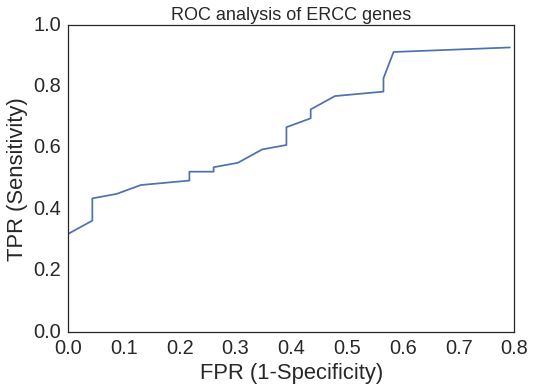

In [105]:
logFC_cutoff=0.5
pval_cutof=0.05
sns.set(style="white",font_scale=2)  
SPs_ERCC={}
SNs_ERCC={}
SNs=[0]
SPs=[1]
my_res=diff_g_res_ercc
for thr in (np.arange(0,3,0.1).tolist()+range(3,100))[::-1]:
    pval_cutof=10**-thr
    ercc_genes=ercc_control.keys()
    T=set(filter(lambda x:abs(ercc_control[x]["logfc"])>0,ercc_genes))
    F=set(ercc_genes)-set(T)
    homos=set(filter(lambda x:sign(my_res[x][0])==sign(ercc_control[x]["logfc"]),my_res.keys()))
    P=set(filter(lambda x:my_res[x][1]<=pval_cutof,my_res.keys()))
    N=set(filter(lambda x:my_res[x][1]>pval_cutof,my_res.keys()))
    N=N|(set(ercc_genes)-(P|N))                                
    TP=T&P&homos
    FP=(P&F)|(P&(T-homos))
    TN=F&N
    FN=T&N
    SN=len(TP)/float(len(TP)+len(FN)+0.0001)
    SP=len(TN)/float(len(TN)+len(FP)+0.0001)
    SNs.append(SN)
    SPs.append(SP)
plot(1-np.array(SPs),SNs)
xlabel("FPR (1-Specificity)")
ylabel("TPR (Sensitivity)")
title("ROC analysis of ERCC genes",fontsize=18)

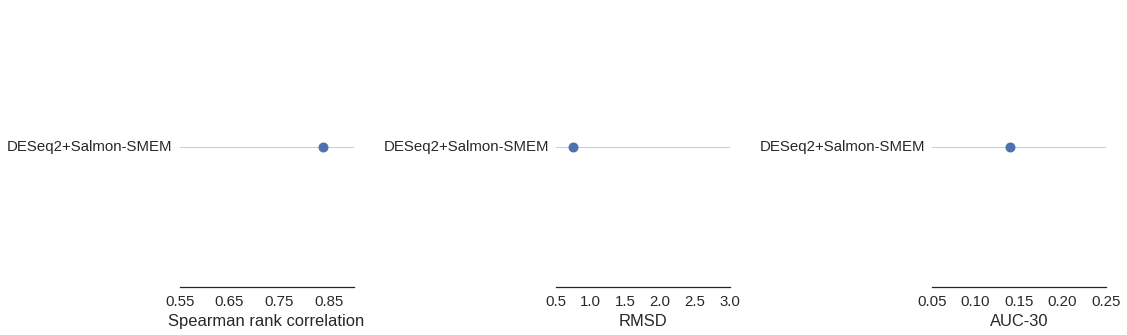

In [109]:
sns.set(style="white",font_scale=1.5)    
my_data=DataFrame([["DESeq2+Salmon-SMEM",ercc_corr["spearman"][0],"Spearman rank correlation"],
                  ["DESeq2+Salmon-SMEM",ercc_corr["RMSD"],"RMSD"],
                  ["DESeq2+Salmon-SMEM",AUC_ERCC,"AUC-30"]]
                  ,
                  columns=["tool","score","Measure"])
fig, axes = plt.subplots(1,3,figsize=(16,5))
for iii,key in enumerate(["Spearman rank correlation","RMSD","AUC-30"]):
    ax=axes[iii]
    my_data_=my_data[my_data["Measure"]==key]
    my_data_=my_data_.sort_values(by='score', ascending=[1 if key=="RMSD" else 0])

    cg=sns.stripplot(y="tool", x="score",data=my_data_,size=10, hue="Measure", orient="h",edgecolor="gray",ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel(key)
    ax.legend([])
    ax.xaxis.grid(False)
    if iii==0:
        ax.set_xticks(np.arange(0.55,0.95,.1))
        ax.set_xlim([0.55,0.9])
    elif iii==1:
        ax.set_xticks(np.arange(0.5,3.5,.5))
        ax.set_xlim([0.5,3])
    elif iii==2:
        ax.set_xticks(np.arange(0.05,0.3,.05))
        ax.set_xlim([0.05,0.25])
    ax.yaxis.grid(True)
    sns.despine(bottom=True)
    sns.despine(top=True)
    sns.despine(right=True)
    sns.despine(left=True)
    plt.tight_layout()
